In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import network

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import colors
from activation_functions import Sigmoid, ReLU
from utils import SingleClassError, MultiClassError, one_hot_encoder


from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    multilabel_confusion_matrix,
)


mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["figure.figsize"] = 10, 5


## Classification with Moons dataset

<AxesSubplot:xlabel='x', ylabel='y'>

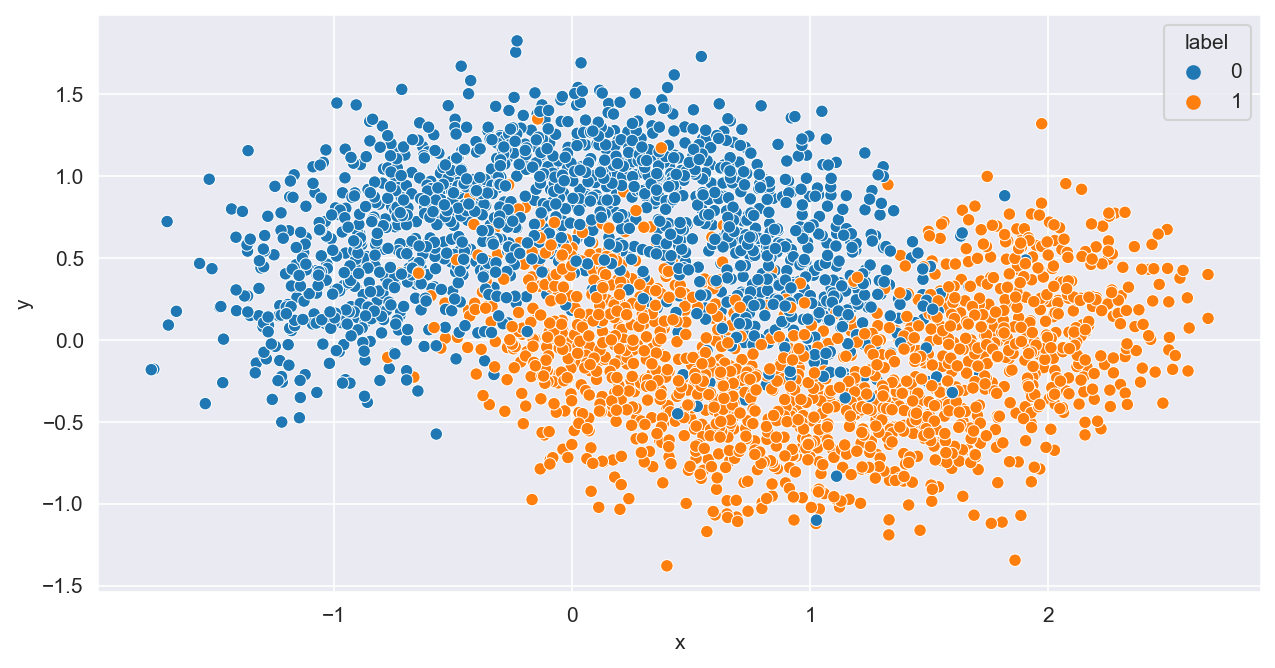

In [63]:
x, y = make_moons(n_samples = 3000, noise=0.3, random_state=200)
moons = pd.DataFrame(x, columns=['x', 'y'])
moons['label'] = y
sns.set_style("darkgrid")
sns.scatterplot(moons, x='x', y= 'y', hue='label',)

In [64]:
x = moons[["x", "y"]].to_numpy()
y = moons["label"].to_numpy()

x_train, x_test_val, y_train, y_test_val = train_test_split(
    x, y, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_test_val, y_test_val, test_size = .25
)

### Create new model with 2 hidden layers

In [65]:
net = network.Network(2)
net.add_layer(8, ReLU())
net.add_layer(8, ReLU())
net.add_output_layer(1, Sigmoid(0.9)) 
stats = net.train(
    x_train, y_train, x_val, y_val, 
    estimator=SingleClassError(),
    eta=10e-3,
    epochs=25,
    verbose=False
)

Epoch : 25 -  Training Loss: 0.1338 - Validaition Loss 0.1541
------------------------------------------------------------


### Some fancy numbers

> Model accuracy: 86.0%. ROC AUC Score: 0.86


<AxesSubplot:>

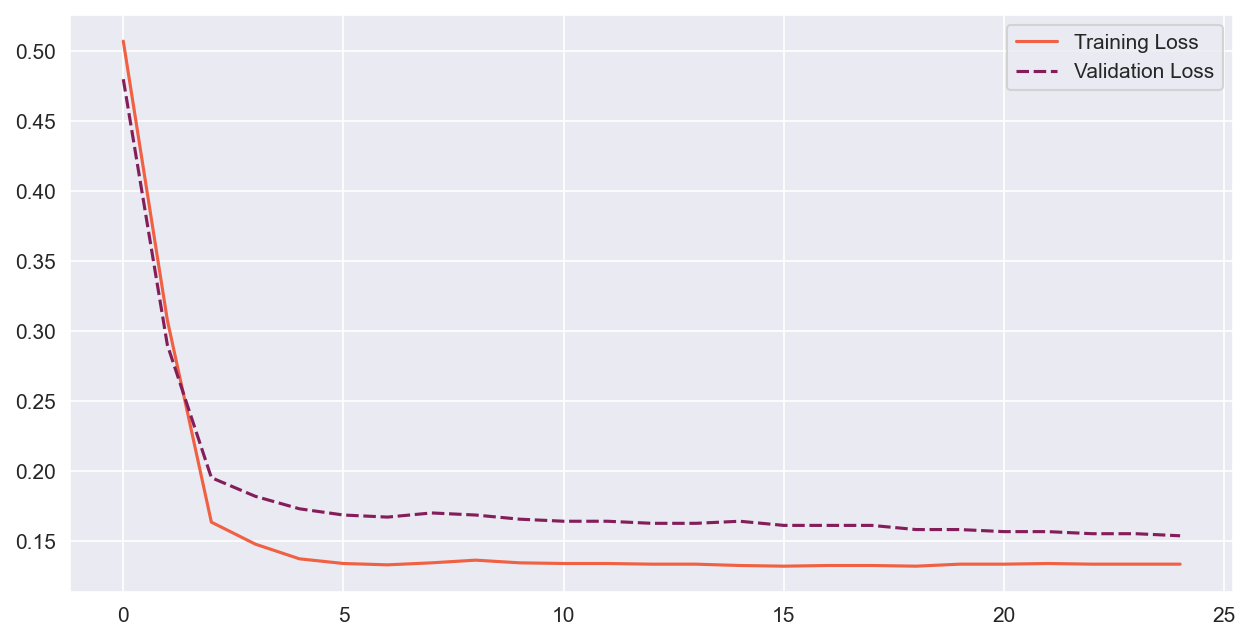

In [66]:
predictions = []

for p in x_test:
    predictions.append(round(net.output(p)[0]))

predictions = np.array(predictions) 

accuracy = round(accuracy_score(y_test, predictions), 2)*100
roc = round(roc_auc_score(y_test, predictions), 2)
fpr, tpr, _ = roc_curve(y_test, predictions)
print(f'> Model accuracy: {accuracy}%. ROC AUC Score: {roc}')

losses = pd.DataFrame({'Training Loss':stats[0], 'Validation Loss':stats[1]})

palette = sns.color_palette("rocket_r", 2)
sns.set_style("darkgrid")
sns.lineplot(losses, palette=palette)


Make 

<AxesSubplot:>

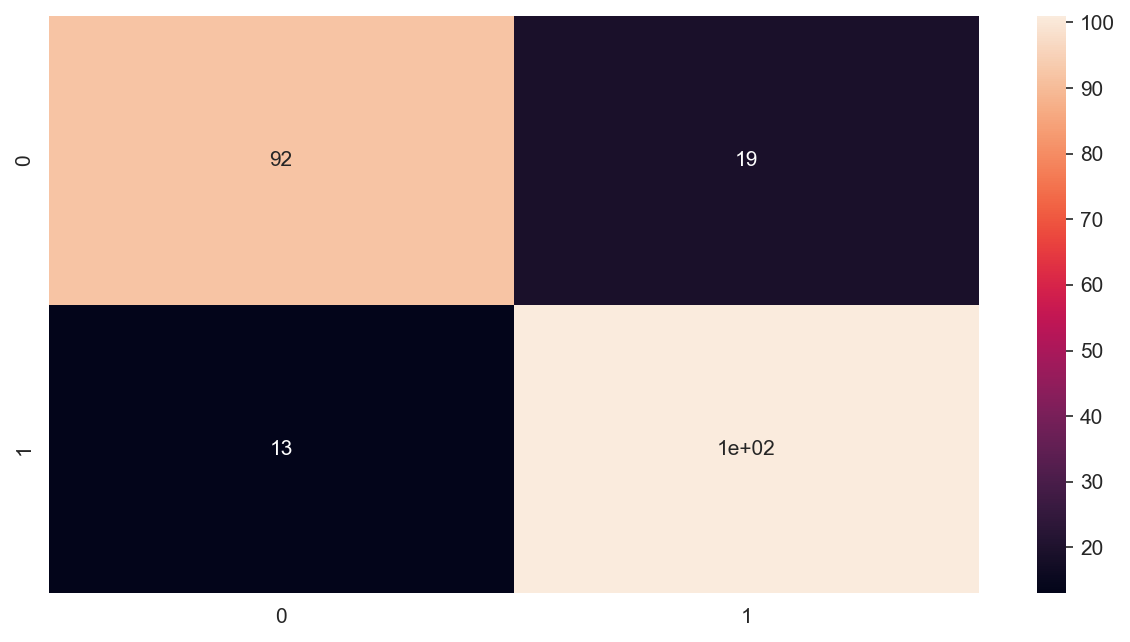

In [67]:
C = confusion_matrix(y_test, predictions)
sns.heatmap(C, annot=True)

## Classification with MNIST handwritten digits dataset

Import dataset and split it into train, validation (for model selection) and test set to evaluate performance. 
Since we're using a 28*28 = 784 long vector, we normalize values to prevent Sigmoid gradient vanishing

In [68]:
mnist_train = pd.read_csv('../data/mnist/train.csv')

y_train = one_hot_encoder(mnist_train[:30000]['label'].to_numpy())
x_train = mnist_train[:30000].drop(['label'], axis=1).to_numpy()
x_train = (x_train / 255)*.1 # type: ignore

y_valid = one_hot_encoder(mnist_train[30000:36000]['label'].to_numpy())
x_valid = mnist_train[30000:36000].drop(['label'], axis=1).to_numpy()
x_valid = (x_valid / 255)*.1  # type: ignore

y_test = one_hot_encoder(mnist_train[30000:36000]['label'].to_numpy())
x_test = mnist_train[30000:36000].drop(['label'], axis=1).to_numpy()
x_test = (x_test / 255)*.1  # type: ignore


In [69]:
net = network.Network(28*28)
net.add_layer(16, ReLU())
net.add_layer(8, ReLU())
net.add_output_layer(10, Sigmoid(a=0.005))

stats = net.train(
    x_train, y_train, x_valid, y_valid, 
    MultiClassError(),
    epochs=10, 
    eta=10e-3,
    verbose=False
)

Epoch : 10 -  Training Loss: 0.083 - Validaition Loss 0.0913
------------------------------------------------------------


In [70]:
predictions = []

for p in x_test:
    predictions.append(np.round(net.output(p)))

predictions = np.array(predictions) 

> Model accuracy: 87.0%. ROC AUC Score: 0.94


<AxesSubplot:>

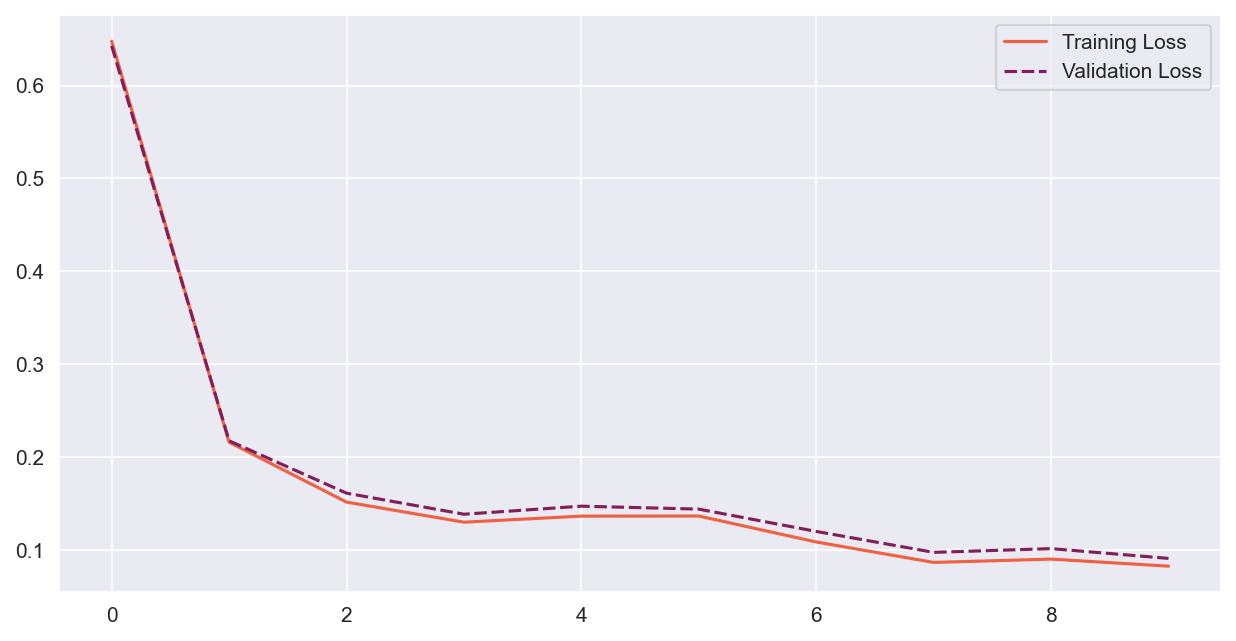

In [71]:
accuracy = round(accuracy_score(y_test, predictions), 2)*100
roc = round(roc_auc_score(y_test, predictions), 2)

print(f'> Model accuracy: {accuracy}%. ROC AUC Score: {roc}')

losses = pd.DataFrame({'Training Loss':stats[0], 'Validation Loss':stats[1]})

palette = sns.color_palette("rocket_r", 2)
sns.set_style("darkgrid")
sns.lineplot(losses, palette=palette)

<AxesSubplot:>

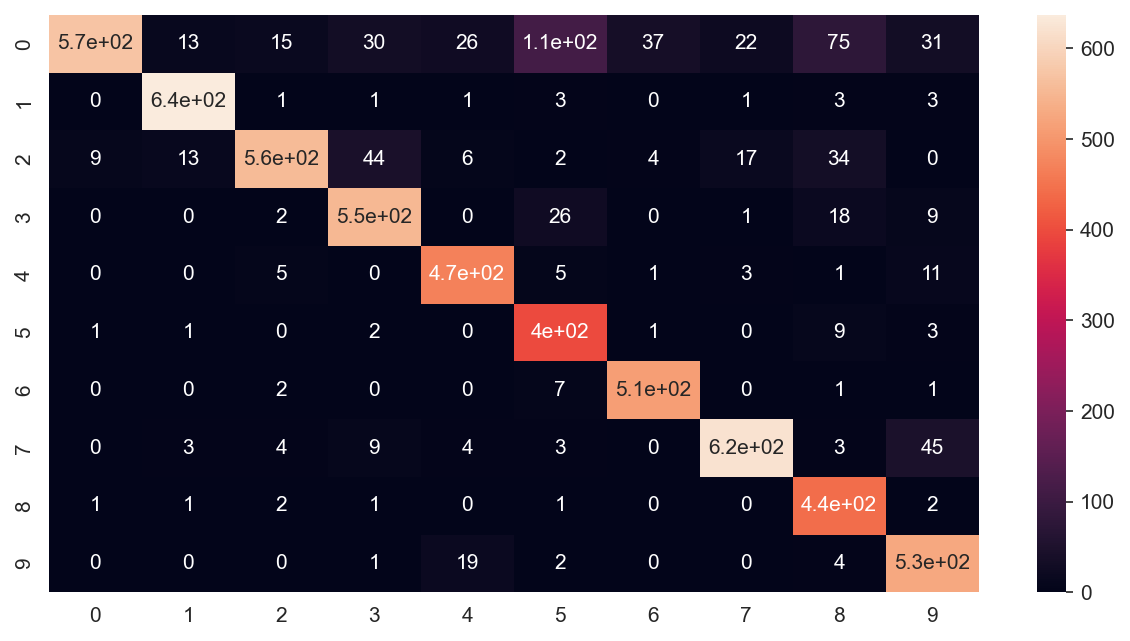

In [76]:
labels_pred = np.argmax(predictions, 1)
labels_true = np.argmax(y_test, 1)

C = confusion_matrix(labels_pred, labels_true)
sns.heatmap(C, annot=True)
